#1. Support Vector Machine (SVM)  

This is the second assignement of the Computational Intelligence course. It includes two main parts:

- First, using SVM to create a binary classifier to predict whether the citizen’s income exceeds fifty thousand dollars a year. 
- And the second one is implement K-Nearest Neighbor(KNN) for the same problem.


Let's get into the first part!

## 1.1 - Packages

Let's first import all the packages that we will need during this assignment. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [pandas](https://pandas.pydata.org/) is a library to oraganize the datasets.
- [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) to preprocess our dataset.
- [sklearn.model_selection](https://scikit-learn.org/stable/modules/preprocessing.html) to split our dataset into train-valid-test sets.
- [sklearn.svm](https://scikit-learn.org/stable/modules/svm.html) is a library for training our model with Support Vector Machines.

In [48]:
import numpy as np
from numpy import transpose as T  
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler
from sklearn.impute import MissingIndicator, KNNImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
import requests
from io import StringIO

## 1.2 - Data Exploration

The dataset has been downloaded from [KEEL](https://sci2s.ugr.es/keel/dataset.php?cod=192#sub1). The Adult data set was extracted in 1994 from census data of the United States. It contains continuous and nominal attributes, describing some social information (age, race, sex, marital status, ...) about the citizens registered.


Run the cell below to download it from my [Google-Drive](https://drive.google.com/file/d/1M1TxV8axXjV_5AnV3oAUxC3HShzuf5hm/view?usp=sharing). Then see some of the samples of dataset:


In [49]:
#download the dat file from my G-Drive
orig_url='https://drive.google.com/file/d/1M1TxV8axXjV_5AnV3oAUxC3HShzuf5hm/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
print("Downloading the dataset...\n")
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw, header=None)
print("The dataset header samples:", "\n")
print(df.head()) #see some of the first samples


The dataset header samples: 

   0          1       2             3   4   ...    10 11  12             13     14
0  25    Private  226802          11th   7  ...     0  0  40  United-States  <=50K
1  38    Private   89814       HS-grad   9  ...     0  0  50  United-States  <=50K
2  28  Local-gov  336951    Assoc-acdm  12  ...     0  0  40  United-States   >50K
3  44    Private  160323  Some-college  10  ...  7688  0  40  United-States   >50K
4  18          ?  103497  Some-college  10  ...     0  0  30  United-States  <=50K

[5 rows x 15 columns]


In [50]:
data = df.to_numpy() #convert the data-frame to numpy array

m = data.shape[0] #number of examples

x = data[:, :-1]
n = x.shape[1]  #number of features

y = data[:, -1]

print("Total features shape:", x.shape)
print("Total targets shape:", y.shape)

print("Number of examples: ", m)
print("Number of features: ", n)

Total features shape: (48842, 14)
Total targets shape: (48842,)
Number of examples:  48842
Number of features:  14


## 1.3 - Preprocessing
The dataset has 14 feautures. There are two main types of data in the dataset:

1. <strong>Numerical feature vectors:</strong>
  - Age, Fnlwgt, Education-num, Capital-gain, Capital-loss, Hours-per-week.
2. <strong>Categorical feature vectors:</strong>
  - Workclass, Education, Marital-status, Occupation, Relationship, Race, Sex, Native-country.

Therfore, we use <strong>One-hot Encoding</strong> and <strong>Binning</strong> techniques in order to make our dataset appropriate for the learning algorithm which we want to train:
1. <strong>One-hot Encoding:</strong>
  - Workclass, Education, Marital-status, Occupation, Relationship, Race, Sex, Native-country.
2. <strong>Binning:</strong>
  - Age.


Run the cell below to observe a random sample of the dataset:

In [51]:
random_sample = x[np.random.randint(m), :].reshape(1,n)
print("random sample:", random_sample)

random sample: [[44 'Private' 346081 'HS-grad' 9 'Divorced' 'Prof-specialty'
  'Not-in-family' 'White' 'Male' 0 0 40 'United-States']]


### 1.3.1 - Missing Features

In some examples, values of some features are missing. There are several approaches to deal with missing features.

Firstly, we should know how much data has missing features.

In [52]:
#number of the exaples which contain missing efatures

indicator = MissingIndicator(missing_values='?', features='all')
indicator.fit(x)

x_tr = indicator.transform(x) #create a boolean matrix indicating which features are missing in the dataset
missing_idx = np.where(np.any(x_tr, axis=1) == True)
print("Number of examples with missing features", np.size(missing_idx), "~", np.size(missing_idx)/m, "% of total examples")



Number of examples with missing features 3620 ~ 0.07411653904426518 % of total examples


There are three main ways to deal with missing features:
- <strong>Removing</strong>: To remove the examples with missing features from the dataset (that
can be done if our dataset is big enough so we can sacrifice some
training examples).

- Using a <strong>learning algorithm</strong> that can deal with missing feature values
(depends on the library and a specific implementation of the
algorithm).

- <strong>Data imputation</strong> techniques.

#### 1.3.1.1 - Removing

<strong>Removing</strong> method is the easiest one. In addition, only 7% of the examples are missing.

In [53]:
x = np.delete(x, missing_idx, axis=0)
y = np.delete(y, missing_idx, axis=0)

print("Total features shape:", x.shape)
print("Total targets shape:", y.shape)

m, n = x.shape

print("Number of examples: ", m)
print("Number of features: ", n)

Total features shape: (45222, 14)
Total targets shape: (45222,)
Number of examples:  45222
Number of features:  14


### 1.3.2 - One-Hot-Encoding

So we can see which columns are referring to a categorized feature:

For One-Hot-encoding we split-out the categorized features to encode them separately. 

In [54]:
categorized_idx = [1, 3, 5, 6, 7, 8, 9, 13] #categorized fetures indexes in the main x

categorized_features = x[:, categorized_idx]

print("categorized features from a random_sample", random_sample[:, categorized_idx])

categorized features from a random_sample [['Private' 'HS-grad' 'Divorced' 'Prof-specialty' 'Not-in-family' 'White'
  'Male' 'United-States']]


In [55]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categorized_features)

one_hot_categorized_features = enc.transform(categorized_features).toarray()
names = enc.get_feature_names(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

print('categorized in one-hot representation shape:', one_hot_categorized_features.shape)
print('\nname of the categories:', names)

categorized in one-hot representation shape: (45222, 98)

name of the categories: ['workclass_Federal-gov' 'workclass_Local-gov' 'workclass_Private'
 'workclass_Self-emp-inc' 'workclass_Self-emp-not-inc'
 'workclass_State-gov' 'workclass_Without-pay' 'education_10th'
 'education_11th' 'education_12th' 'education_1st-4th' 'education_5th-6th'
 'education_7th-8th' 'education_9th' 'education_Assoc-acdm'
 'education_Assoc-voc' 'education_Bachelors' 'education_Doctorate'
 'education_HS-grad' 'education_Masters' 'education_Preschool'
 'education_Prof-school' 'education_Some-college'
 'marital-status_Divorced' 'marital-status_Married-AF-spouse'
 'marital-status_Married-civ-spouse'
 'marital-status_Married-spouse-absent' 'marital-status_Never-married'
 'marital-status_Separated' 'marital-status_Widowed'
 'occupation_Adm-clerical' 'occupation_Armed-Forces'
 'occupation_Craft-repair' 'occupation_Exec-managerial'
 'occupation_Farming-fishing' 'occupation_Handlers-cleaners'
 'occupation_Machine-op-

### 1.3.3 - Binning

The only feature which is eligible for binning is <strong>Age</strong>.

For bining we split-out this feature to encode it separately. 

In [56]:
age_idx = [0] #indecis of features which we want to bin

age = np.asarray(x[:, age_idx], dtype=float)

print("categorized features from the random_sample", random_sample[:, age_idx])

categorized features from the random_sample [[44]]


In [57]:
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(age)
binned_features = est.transform(age)

print('binned features shape:', binned_features.shape)

binned features shape: (45222, 1)


### 1.3.4 - Standardization 

Other features in the dataset are real numbers. For better performance, we need to Standardize them by removing the mean and scaling to unit variance.

In [58]:
#real number features
idx = [2, 4, 10, 11, 12]
real_features = np.asarray(x[:, idx], dtype=float)

print("real number features from the random_sample", random_sample[:, idx])


real number features from the random_sample [[346081 9 0 0 40]]


In [59]:
scaler = StandardScaler()
scaler.fit(real_features)
standardized_fetures = scaler.transform(real_features)

print('standardized features: ', standardized_fetures)

standardized features:  [[ 0.35088942 -1.22155881 -0.1467332  -0.21878026 -0.07812006]
 [-0.94587846 -0.43812161 -0.1467332  -0.21878026  0.7547014 ]
 [ 1.39359159  0.73703421 -0.1467332  -0.21878026 -0.07812006]
 ...
 [-0.35805983 -0.43812161 -0.1467332  -0.21878026 -0.07812006]
 [ 0.11127873 -0.43812161 -0.1467332  -0.21878026 -1.74376299]
 [ 0.92951628 -0.43812161  1.85477297 -0.21878026 -0.07812006]]


Now we have to concate the generated feature to rebuild the dataset.

In [60]:

xx = np.append(binned_features, one_hot_categorized_features, axis=1)
xx = np.append(xx, standardized_fetures, axis=1)
xx = np.asarray(xx, dtype=float)

yy = np.zeros((m,))
mask = y[:] == '>50K'
yy[mask,] = 1

print("Total features shape:", xx.shape)
print("Total targets shape:", yy.shape)

m, n = xx.shape

print("Number of examples: ", m)
print("Number of features: ", n)

Total features shape: (45222, 104)
Total targets shape: (45222,)
Number of examples:  45222
Number of features:  104


## 1.4 - Dataset

And finally, this is the time for splitting the dataset into 3 sets.

In [61]:
random_state = 20
train_x, test_x, train_y, test_y = train_test_split(xx, yy, test_size=0.1,random_state=random_state) # train90% valid5% test5% 
valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size=0.50,random_state=random_state)

print("Training set shape:", train_x.shape)
print("Validation set shape:", valid_x.shape)
print("Test set shape:", test_x.shape)


Training set shape: (40699, 104)
Validation set shape: (2261, 104)
Test set shape: (2262, 104)


## 1.5 - Model

Run just one of the cells below:

In [ ]:
model = SVC(kernel='rbf')
history = model.fit(train_x,train_y)

In [ ]:
model = SVC(kernel='linear')
history = model.fit(train_x,train_y)

In [ ]:
model = SVC(kernel='poly', degree=3)
history = model.fit(train_x,train_y)

In [ ]:
model = SVC(kernel='sigmoid')
history = model.fit(train_x,train_y)

## 1.6 - Trying different kernels
The function of kernel is to take data as input and transform it into the required form. Different SVM algorithms use different types of kernel functions. These functions can be different types. For example:
- linear
- polynomial
- Radial Basis Function (RBF)
- sigmoid

We can evaluate each of thease approaches via validation set.

In [ ]:
y_train_pred = model.predict(train_x)
y_valid_pred = model.predict(valid_x)

train_acc = accuracy_score(train_y,y_train_pred)*100
valid_acc = accuracy_score(valid_y,y_valid_pred)*100

print('train accuracy:', train_acc)
print('valid accuracy:', valid_acc)

train accuracy: 86.0831961473255
valid accuracy: 84.91817779743477


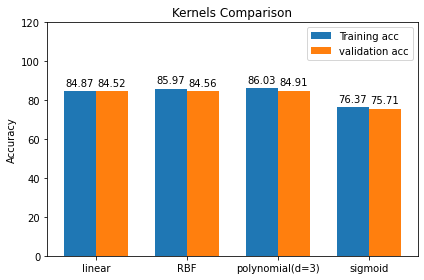

In [ ]:
labels = ['linear', 'RBF', 'polynomial(d=3)', 'sigmoid']
training_acc = [84.87, 85.97, 86.08, 76.37]
valid_acc = [84.52, 84.56, 84.91, 75.71]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training acc')
rects2 = ax.bar(x + width/2, valid_acc, width, label='validation acc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Kernels Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 120)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## 1.6 - Test and Confusion Matrix

In [ ]:
y_test_pred = model.predict(test_x)
test_acc = accuracy_score(test_y,y_test_pred)*100

print('test accuracy:', test_acc)

test accuracy: 85.2343059239611


              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      1723
         1.0       0.74      0.59      0.66       539

    accuracy                           0.85      2262
   macro avg       0.81      0.76      0.78      2262
weighted avg       0.85      0.85      0.85      2262



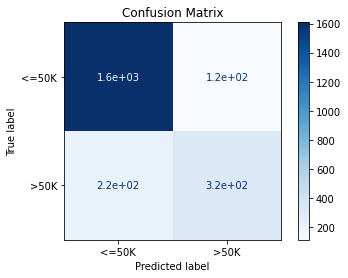

In [ ]:
disp = plot_confusion_matrix(model, test_x, test_y, display_labels=['<=50K', '>50K'], cmap=plt.cm.Blues, normalize=None)
disp.ax_.set_title("Confusion Matrix")

print(classification_report(test_y, y_test_pred))

#1. k-Nearest Neighbors (KNN)  

Creating a KNN classifier can be broken down into several steps:

1. Define a function to calculate the distance between two points.
2. Use the distance function to get the distance between a test point and all known data points.
3. Sort distance measurements to find the points closest to the test point (i.e., find the nearest neighbors).
4. Use majority class labels of those closest points to predict the label of the test point.
5. Repeat steps 1 through 4 until all test data points are classified.


Let's get into the first part!

## 2.1 - Distance function
First, we define a function called <strong>minkowski_distance</strong>, that takes an input of two data points and a Minkowski power parameter p, and returns the distance between the two points.



In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1WFm-ETiXLrWs_81g8To66CDNNK8bUHAA/preview"></iframe>

In [90]:
def minkowski_distance_vectorized(train_x, test_x, train_y, test_y, p=2):
    num_test = test_x.shape[0]
    num_train = train_x.shape[0]
    dists = np.zeros((num_test, num_train))

    train_targets = train_y + np.zeros((num_test, num_train))  
    dists = np.abs((np.sum(np.square(test_x), axis=1, keepdims=True) + np.sum(np.square(train_x), axis=1) - np.multiply(np.dot(test_x, train_x.T), 2))) ** (1/p)

    return dists, train_targets

## 2.2 - Evaluation on the validation set

In this part, we want to evaluate model with different hyperparameters.

In [91]:
max_k = 200
dists, train_targets = minkowski_distance_vectorized(train_x, valid_x, train_y, valid_y, p=2)

print("\nSorting the distances...")
idx = np.argsort(dists, axis = 1)
j = np.arange(len(dists))[:, np.newaxis]

accuracy = []
for i in range(1, max_k+1):

    k_idx = idx[:, :i]
    k_min_dists = dists[j, k_idx]
    k_min_train_targets = train_targets[j, k_idx]

    y_pred = [Counter(col).most_common(1)[0][0] for col in zip(*k_min_train_targets.T)]

    accuracy.append(accuracy_score(valid_y, y_pred))


Sorting the distances...



Best accuracy on the validation set: 0.8474126492702344 for k = 145 



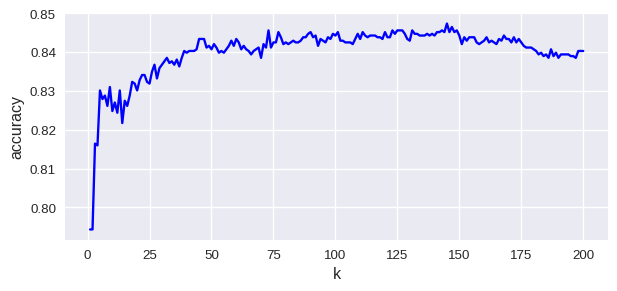

In [94]:
plt.figure(figsize=(700 / 96, 300 / 96), dpi=96)
plt.style.use("seaborn")
plt.plot(range(1, max_k+1), accuracy, 'b-', markersize=3)
plt.xlabel("k", fontsize="12")
plt.ylabel("accuracy", fontsize="12")

best_accuracy = max(accuracy)
best_k = accuracy.index(best_accuracy) + 1
print("\nBest accuracy on the validation set:", best_accuracy, "for k =", best_k, "\n")

##2.3 - Test 

In [96]:
k = best_k
dists, train_targets = minkowski_distance_vectorized(train_x, test_x, train_y, test_y, p=2)

print("\nSorting the distances...")
idx = np.argsort(dists, axis = 1)
j = np.arange(len(dists))[:, np.newaxis]

k_idx = idx[:, :k]
k_min_dists = dists[j, k_idx]
k_min_train_targets = train_targets[j, k_idx]
y_pred = [Counter(col).most_common(1)[0][0] for col in zip(*k_min_train_targets.T)]

print("test_acc: ", accuracy_score(test_y, y_pred)*100)


Sorting the distances...
test_acc:  84.3501326259947


## 2.4 - Scikit Learn KNN

Let's compare th model's performance with the one implemented with SKlearn!

In [83]:
knn_model = KNeighborsClassifier(n_neighbors=145)
knn_model.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=145, p=2,
                     weights='uniform')

In [84]:
y_pred = knn_model.predict(test_x)

test_acc = accuracy_score(test_y,y_pred)*100
print('test accuracy:', test_acc)

test accuracy: 84.3501326259947


You can see my model works well! even faster :)